In [ ]:
!pip install pymysql

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pymysql
import warnings
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')



In [ ]:
host = 'database-mis686-tp.closu2og4z8i.us-east-1.rds.amazonaws.com'
user = 'admin'
password = 'Pitstop2025!'
database = 'restaurantdb'

connection = pymysql.connect(host=host, user=user, passwd=password, database=database)
with connection:
    cur = connection.cursor()
    cur.execute("SELECT VERSION()")
    version = cur.fetchone()
    print("Database version: {} ".format(version[0]))

Database version: 8.0.39 


In [ ]:

def run_query(q: str) -> pd.DataFrame:
    with pymysql.connect(host=host, user=user, passwd=password, database=database) as conn:
        return pd.read_sql(q, conn)


def run_command(c: str):
    with pymysql.connect(host=host, user=user, passwd=password, database=database) as conn:
        conn.isolation_level = None
        conn.execute(c)

In [ ]:
def show_tables() -> pd.DataFrame:
    q = """
          SELECT table_name
          FROM information_schema.tables
          WHERE table_schema = 'restaurantdb' AND table_type = 'BASE TABLE';
        """
    return run_query(q)


def get_table_row_count(tablename) -> int:
    q = (
        """
        SELECT
            COUNT(1)
        FROM %s;
        """
        % tablename
    )
    return run_query(q)["COUNT(1)"][0]


tables = show_tables()
tables["row_count"] = [get_table_row_count(t) for t in tables['TABLE_NAME']]

tables

,TABLE_NAME,row_count
0,Branch,2
1,Customer,20
2,Employee,10
3,OrderItem,17
4,Orders,10
5,Payment,6
6,Reservation,6
7,Role,3
8,TableInfo,12
9,Visit,15


In [ ]:
visits_per_branch_query = """
SELECT
  b.Name AS branch_name,
  COUNT(v.VisitID) AS total_visits
 FROM Visit v
 JOIN Branch b ON b.branchID = v.BranchID
 GROUP BY 1
 ORDER BY total_visits DESC;
 """
visits_per_branch_df = run_query(visits_per_branch_query)
visits_per_branch_df = visits_per_branch_df.rename(columns={
    "branch_name": "Branch",
    "total_visits": "Total Visits"
})

visits_per_branch_df


,Branch,Total Visits
0,Downtown,9
1,Uptown,6


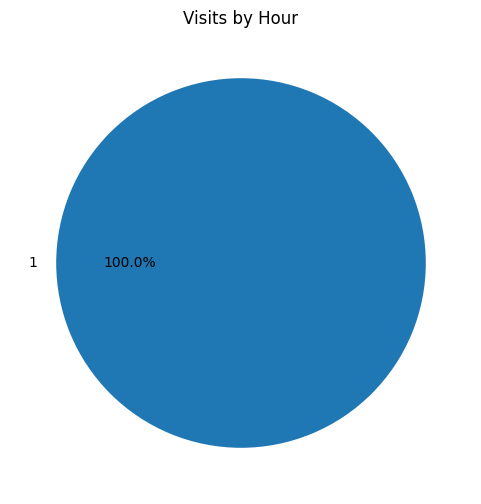

In [ ]:
visits_by_hour_query = """
SELECT
    EXTRACT(HOUR FROM TimeCreated) AS hour_of_day,
    COUNT(*) AS visit_count
FROM Visit
GROUP BY hour_of_day
ORDER BY visit_count DESC;
"""

visits_by_hour_df = run_query(visits_by_hour_query)

plt.figure(figsize=(6,6))
plt.pie(
    visits_by_hour_df["visit_count"],
    labels=visits_by_hour_df["hour_of_day"],
    autopct='%1.1f%%'
)
plt.title("Visits by Hour")
plt.show()

In [ ]:
returning_customers_query = """
SELECT
    c.CustomerID,
    c.FirstName || ' ' || c.LastName AS customer_name,
    COUNT(v.VisitID) AS visit_count
FROM Customer c
JOIN Visit v ON v.CustomerID = c.CustomerID
GROUP BY c.CustomerID
HAVING COUNT(v.VisitID) > 1
ORDER BY visit_count DESC;
"""

returning_customers_df = run_query(returning_customers_query)

if returning_customers_df.empty:
    print("There are no returning customers at this time.")
else:
    returning_customers_df


There are no returning customers at this time.


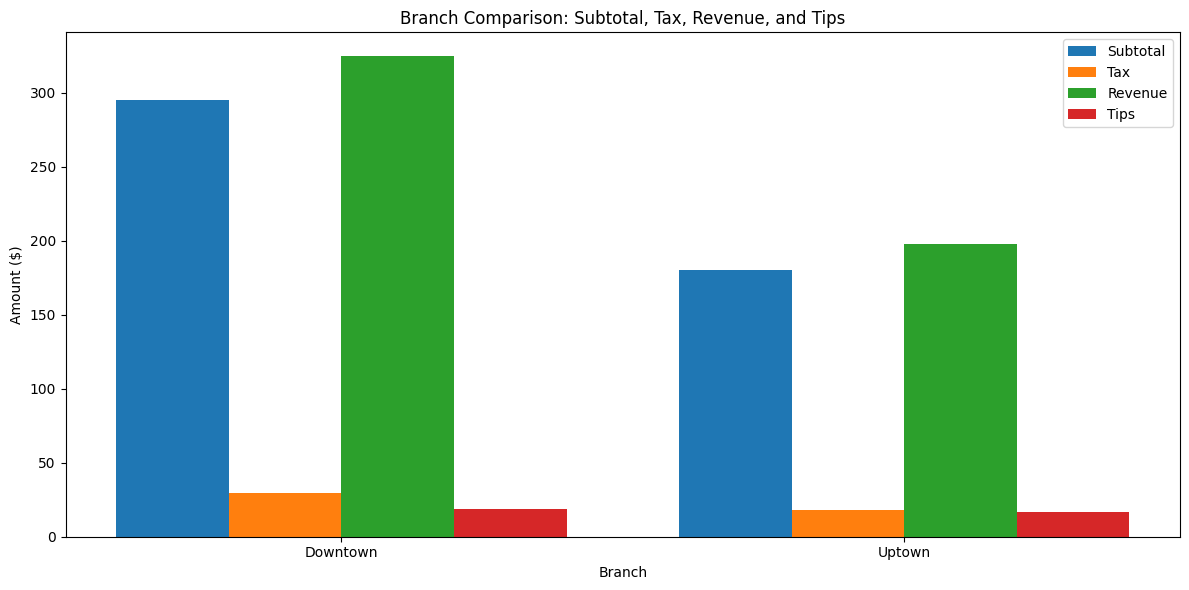

In [ ]:
branch_revenue_query = """
SELECT
    b.Name AS branch_name,
    SUM(o.SubTotal) AS total_subtotal,
    SUM(o.TaxAmount) AS total_tax_collected,
    SUM(o.TotalDue) AS total_revenue,
    SUM(p.Tip) AS total_tips
FROM Orders o
JOIN Visit v ON v.VisitID = o.VisitID
JOIN Branch b ON b.BranchID = v.BranchID
LEFT JOIN Payment p ON p.OrderID = o.OrderID
GROUP BY branch_name
ORDER BY total_revenue DESC;
"""

df = run_query(branch_revenue_query)

labels = df["branch_name"]
subtotal = df["total_subtotal"]
tax = df["total_tax_collected"]
revenue = df["total_revenue"]
tips = df["total_tips"]

x = np.arange(len(labels))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - width*1.5, subtotal, width, label="Subtotal")
plt.bar(x - width*0.5, tax, width, label="Tax")
plt.bar(x + width*0.5, revenue, width, label="Revenue")
plt.bar(x + width*1.5, tips, width, label="Tips")

plt.xlabel("Branch")
plt.ylabel("Amount ($)")
plt.title("Branch Comparison: Subtotal, Tax, Revenue, and Tips")
plt.xticks(x, labels)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
avg_spending_query = """
SELECT
    c.CustomerID,
    CONCAT(c.FirstName, ' ', c.LastName) AS customer_name,
    ROUND(AVG(o.TotalDue), 2) AS avg_spending
FROM Customer c
JOIN Visit v ON v.CustomerID = c.CustomerID
JOIN Orders o ON o.VisitID = v.VisitID
GROUP BY c.CustomerID
ORDER BY avg_spending DESC;
"""

avg_spending_df = run_query(avg_spending_query)

avg_spending_df = avg_spending_df.rename(columns={
    "customer_name": "Customer",
    "avg_spending": "Avg Spending ($)"
})

avg_spending_df["Avg Spending ($)"] = avg_spending_df["Avg Spending ($)"].round(2)

avg_spending_df


,CustomerID,Customer,Avg Spending ($)
0,7,Noah Lopez,99.0
1,15,James Martin,88.0
2,5,David Garcia,66.0
3,13,Ethan Moore,60.5
4,10,Mia Anderson,46.2
5,2,Sophia Lee,44.0
6,12,Isabella Taylor,36.3
7,3,Michael Brown,30.8
8,8,Ava Hernandez,27.5
9,14,Amelia Jackson,24.2


In [ ]:
avg_wait_query = """
SELECT
    ROUND(AVG(Quoted_wait_time), 2) AS avg_wait_minutes
FROM Waitlist
WHERE Status = 'Waiting';
"""

avg_wait_df = run_query(avg_wait_query)

avg_wait = avg_wait_df["avg_wait_minutes"].iloc[0]
print(f"\n Average Wait Time\n   {avg_wait:.1f} minutes\n")


 Average Wait Time
   20.0 minutes



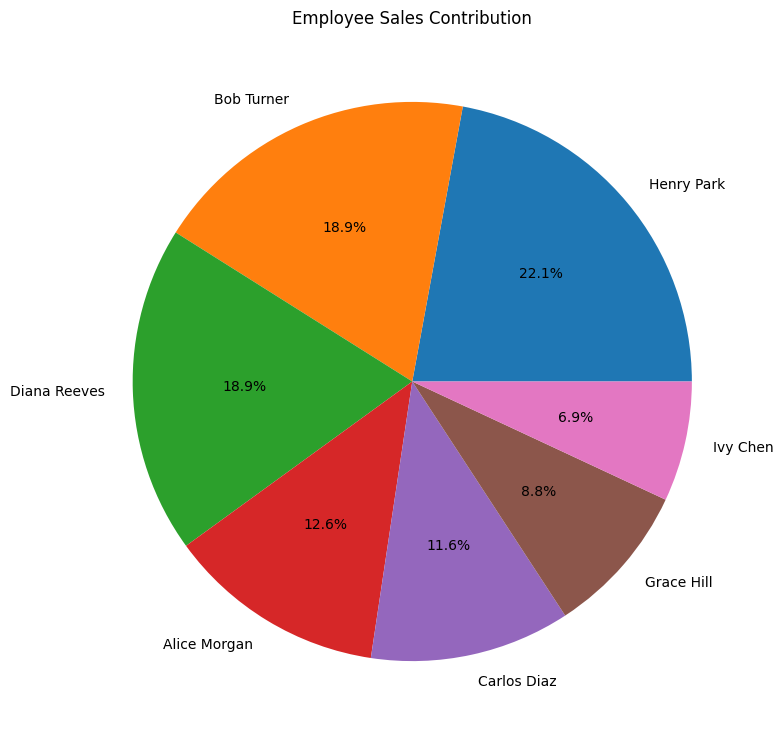

In [ ]:
employee_sales_query = """
SELECT
    CONCAT(e.FirstName, ' ', e.LastName) AS employee_name,
    b.Name AS branch_name,
    SUM(o.TotalDue) AS total_sales
FROM Orders o
JOIN Employee e ON e.EmployeeID = o.EmployeeID
JOIN Branch b ON b.BranchID = e.BranchID
GROUP BY employee_name, branch_name
ORDER BY total_sales DESC;
"""

employee_sales_df = run_query(employee_sales_query)

plt.figure(figsize=(8, 8))
plt.pie(
    employee_sales_df["total_sales"],
    labels=employee_sales_df["employee_name"],
    autopct='%1.1f%%'
)

plt.title("Employee Sales Contribution")
plt.tight_layout()
plt.show()

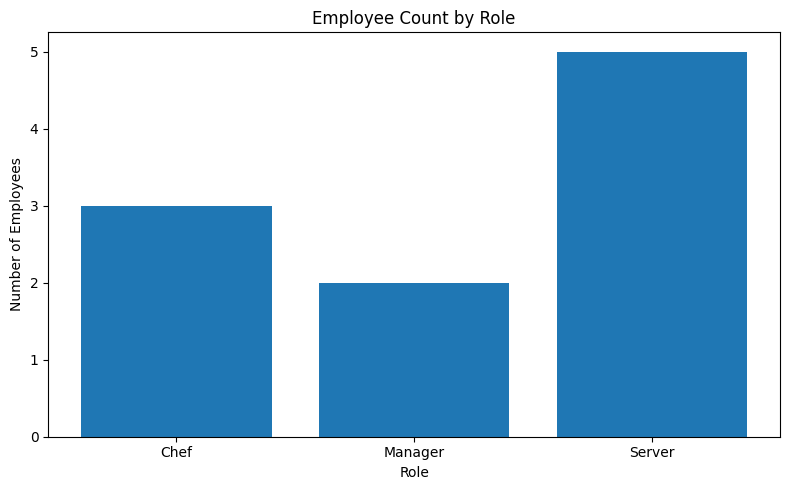

In [ ]:
role_count_query = """
SELECT
    r.RoleName,
    COUNT(e.EmployeeID) AS employee_count
FROM Role r
LEFT JOIN Employee e ON e.RoleID = r.RoleID
GROUP BY r.RoleName;
"""

role_count_df = run_query(role_count_query)

plt.figure(figsize=(8,5))
plt.bar(role_count_df["RoleName"], role_count_df["employee_count"])

plt.title("Employee Count by Role")
plt.xlabel("Role")
plt.ylabel("Number of Employees")

plt.tight_layout()
plt.show()

In [ ]:
import base64
from io import BytesIO

def fig_to_html(fig):
    buf = BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode("utf-8")
    return f'<img src="data:image/png;base64,{img_base64}" style="width:100%;">'


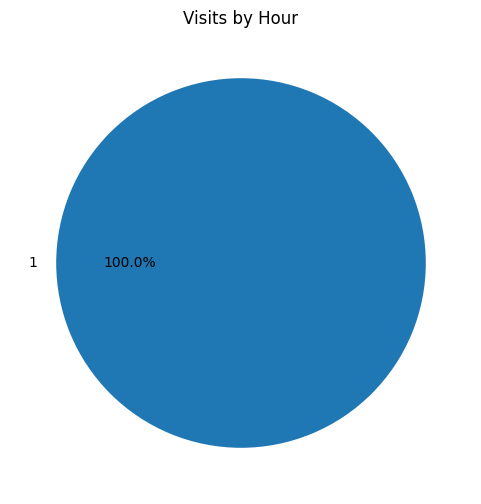

In [ ]:
fig_visits_hour = plt.figure(figsize=(6,6))
plt.pie(
    visits_by_hour_df["visit_count"],
    labels=visits_by_hour_df["hour_of_day"],
    autopct='%1.1f%%'
)
plt.title("Visits by Hour")
visits_hour_html = fig_to_html(fig_visits_hour)


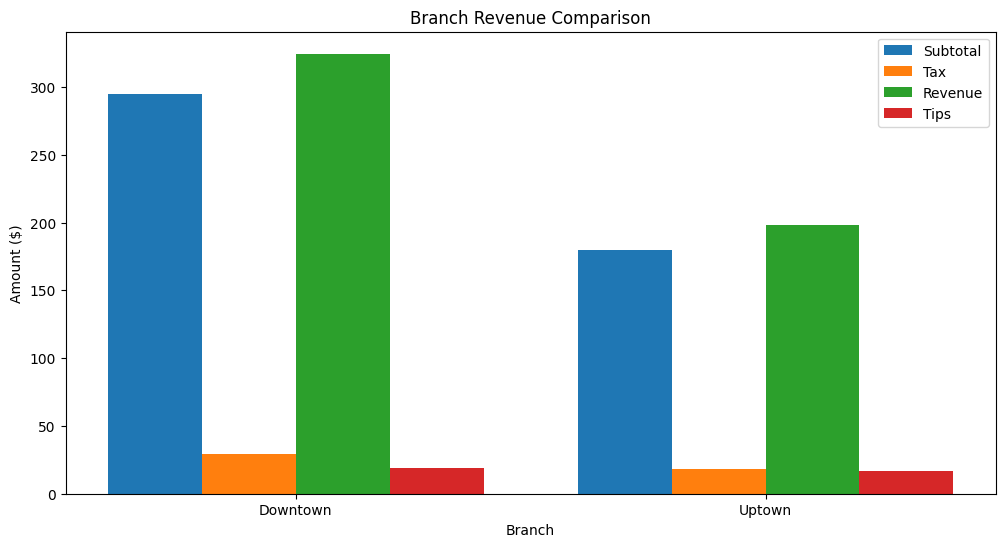

In [ ]:
fig_revenue = plt.figure(figsize=(12,6))
plt.bar(x - width*1.5, subtotal, width, label="Subtotal")
plt.bar(x - width*0.5, tax, width, label="Tax")
plt.bar(x + width*0.5, revenue, width, label="Revenue")
plt.bar(x + width*1.5, tips, width, label="Tips")
plt.legend()
plt.title("Branch Revenue Comparison")
plt.xlabel("Branch")
plt.ylabel("Amount ($)")
plt.xticks(x, labels)
revenue_html = fig_to_html(fig_revenue)


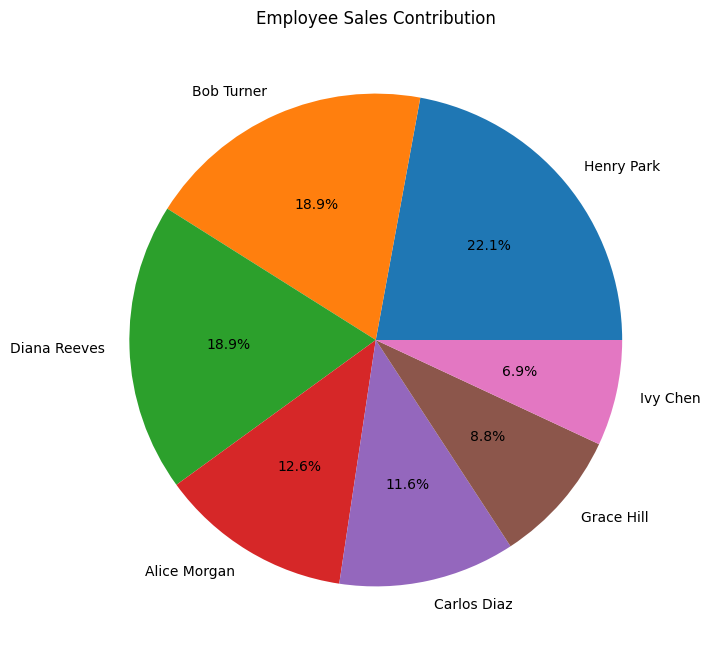

In [ ]:
fig_sales = plt.figure(figsize=(8,8))
plt.pie(
    employee_sales_df["total_sales"],
    labels=employee_sales_df["employee_name"],
    autopct='%1.1f%%'
)
plt.title("Employee Sales Contribution")
employee_sales_html = fig_to_html(fig_sales)


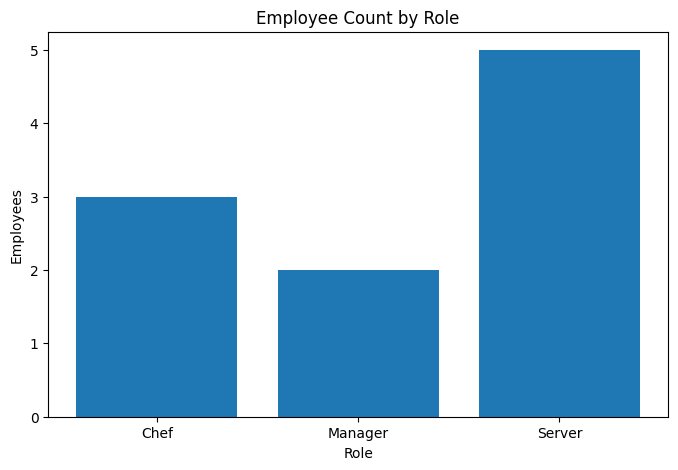

In [ ]:
fig_roles = plt.figure(figsize=(8,5))
plt.bar(role_count_df["RoleName"], role_count_df["employee_count"])
plt.title("Employee Count by Role")
plt.xlabel("Role")
plt.ylabel("Employees")
roles_html = fig_to_html(fig_roles)


In [ ]:
visits_per_branch_html     = visits_per_branch_df.to_html(index=False, classes="data-table")
avg_spending_html          = avg_spending_df.to_html(index=False, classes="data-table")
role_count_html            = role_count_df.to_html(index=False, classes="data-table")

# Returning customers table — handle empty case
if returning_customers_df.empty:
    returning_customers_html = "<p>No returning customers found.</p>"
else:
    returning_customers_html = returning_customers_df.to_html(index=False, classes="data-table")


In [ ]:
customers = tables[tables["TABLE_NAME"]=="Customer"]["row_count"].values[0]
employees = tables[tables["TABLE_NAME"]=="Employee"]["row_count"].values[0]
orders     = tables[tables["TABLE_NAME"]=="Orders"]["row_count"].values[0]
avg_wait   = avg_wait_df["avg_wait_minutes"].iloc[0]

metric_cards_html = f"""
<div class="metrics-row">

    <div class="metric-card">
        <div class="metric-number">{customers:,}</div>
        <div class="metric-label">Total Customers</div>
    </div>

    <div class="metric-card">
        <div class="metric-number">{employees:,}</div>
        <div class="metric-label">Total Employees</div>
    </div>

    <div class="metric-card">
        <div class="metric-number">{orders:,}</div>
        <div class="metric-label">Total Orders</div>
    </div>

    <div class="metric-card">
        <div class="metric-number">{avg_wait:.1f} min</div>
        <div class="metric-label">Avg Wait Time</div>
    </div>

</div>
"""


In [ ]:
html_template = f"""
<!DOCTYPE html>
<html>
<head>
    <meta charset="utf-8">
    <title>Restaurant Dashboard</title>

    <style>
        body {{
            font-family: Arial, sans-serif;
            margin: 0;
            padding: 0;
            background: #f1ede4;
        }}
        header {{
            background: #e8dfcf;
            padding: 16px 24px;
        }}
        .container {{
            padding: 24px;
        }}
        .metrics-row {{
            display: flex;
            gap: 24px;
            margin-bottom: 32px;
            flex-wrap: wrap;
        }}
        .metric-card {{
            background: white;
            padding: 16px 20px;
            border-radius: 10px;
            box-shadow: 0 2px 5px rgba(0,0,0,0.1);
            flex: 1 1 200px;
            min-width: 180px;
            border-left: 12px solid #3d7f3a;
        }}
        .metric-number {{
            font-size: 32px;
            font-weight: bold;
            color: #333;
            margin-bottom: 4px;
        }}
        .metric-label {{
            font-size: 14px;
            color: #555;
        }}
        .row {{
            display: flex;
            flex-wrap: wrap;
            gap: 24px;
        }}
        .card {{
            background: white;
            padding: 16px;
            border-radius: 8px;
            box-shadow: 0 2px 4px rgba(0,0,0,0.08);
            flex: 1 1 400px;
        }}

        /* ------- TABLE STYLING (updated for readability) ------- */

        .data-table {{
            border-collapse: collapse;
            width: 100%;
            font-size: 12px;
            color: #222; /* readable dark grey */
        }}

        .data-table th {{
            background: #3d7f3a;   /* dark green header bar */
            color: #ffffff;        /* white header text */
            padding: 6px 8px;
            text-align: left;
            font-weight: bold;
        }}

        .data-table td {{
            border: 1px solid #ccc;
            padding: 6px 8px;
            text-align: left;
            background: #fafafa;   /* soft grey row background */
        }}

        .data-table tr:nth-child(even) td {{
            background: #f0f0f0;   /* zebra stripes */
        }}

    </style>
</head>

<body>
<header>
    <h1>Restaurant Analytics Dashboard</h1>
</header>

<div class="container">

    {metric_cards_html}

    <!-- CHART ROW 1 -->
    <div class="row">
        <div class="card">
            <h2>Visits by Hour</h2>
            {visits_hour_html}
        </div>

        <div class="card">
            <h2>Branch Revenue Comparison</h2>
            {revenue_html}
        </div>
    </div>

    <!-- CHART ROW 2 -->
    <div class="row" style="margin-top:24px;">
        <div class="card">
            <h2>Employee Sales</h2>
            {employee_sales_html}
        </div>

        <div class="card">
            <h2>Employees per Role</h2>
            {roles_html}
        </div>
    </div>

    <!-- TABLE ROW 1 -->
    <div class="row" style="margin-top:24px;">
        <div class="card">
            <h2>Visits per Branch</h2>
            {visits_per_branch_html}
        </div>

        <div class="card">
            <h2>Customer Average Spending</h2>
            {avg_spending_html}
        </div>
    </div>

    <!-- TABLE ROW 2 -->
    <div class="row" style="margin-top:24px;">
        <div class="card">
            <h2>Employees per Role</h2>
            {role_count_html}
        </div>

        <div class="card">
            <h2>Returning Customers</h2>
            {returning_customers_html}
        </div>
    </div>

</div>
</body>
</html>
"""


✅ Dashboard saved as: restaurant_report.html



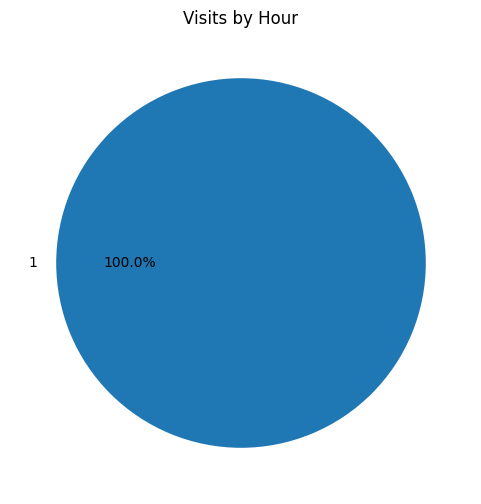
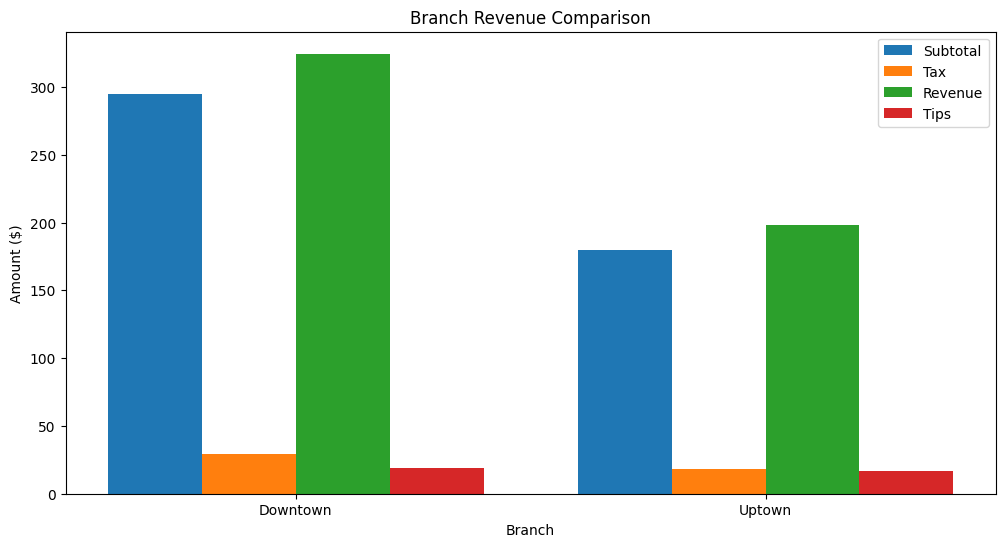
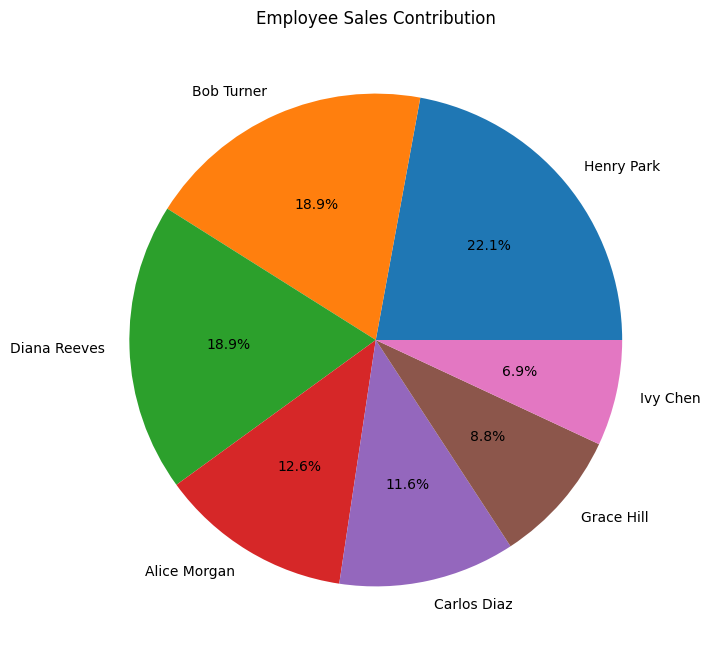
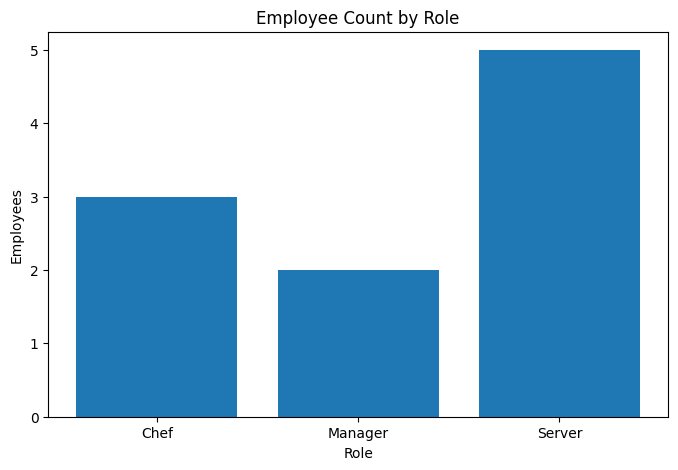

In [ ]:
output_file = "restaurant_report.html"

with open(output_file, "w", encoding="utf-8") as f:
    f.write(html_template)

print(f"✅ Dashboard saved as: {output_file}")

from IPython.display import HTML
HTML(open(output_file, "r").read())
